In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
runs = [
  # B params, device, nvlink, tp, pp, path
    (      8, "A100",   None,  0,  0, "llama-3.1-8b-a100-single-gpu.txt"),
    (      8, "A100",  False,  0,  2, "llama-3.1-8b-a100-wo-nvlink-tp0-pp2.txt"),
    (      8, "A100",  False,  2,  0, "llama-3.1-8b-a100-wo-nvlink-tp2-pp0.txt"),
    (      8, "H200",   None,  0,  0, "llama-3.1-8b-h200-single-gpu.txt"),
    (      8, "H200",   True,  0,  2, "llama-3.1-8b-h200-w-nvlink-tp0-pp2.txt"),
    (      8, "H200",   True,  2,  0, "llama-3.1-8b-h200-w-nvlink-tp2-pp0.txt"),
    (      8, "H200",  False,  0,  2, "llama-3.1-8b-h200-wo-nvlink-tp0-pp2.txt"),
    (      8, "H200",  False,  2,  0, "llama-3.1-8b-h200-wo-nvlink-tp2-pp0.txt"),
    # (     70, "A100",   None,  0,  4, "llama-3.1-70b-a100-tp0-pp4.txt"), # does not run
    (     70, "A100",   None,  2,  2, "llama-3.1-70b-a100-tp2-pp2.txt"),
    (     70, "A100",   None,  4,  0, "llama-3.1-70b-a100-tp4-pp0.txt"),
    (     70, "H200",   None,  0,  4, "llama-3.1-70b-h200-tp0-pp4.txt"),
    (     70, "H200",   None,  2,  2, "llama-3.1-70b-h200-tp2-pp2.txt"),
    (     70, "H200",   None,  4,  0, "llama-3.1-70b-h200-tp4-pp0.txt"),
    (    405, "H200",   None,  0,  8, "llama-3.1-405b-tp0-pp8.txt"),
    (    405, "H200",   None,  2,  4, "llama-3.1-405b-tp2-pp4.txt"),
    (    405, "H200",   None,  4,  2, "llama-3.1-405b-tp4-pp2.txt"),
    (    405, "H200",   None,  8,  0, "llama-3.1-405b-tp8-pp0.txt"),
]

In [3]:
results = []
for params, device, nvlink, tp, pp, path in runs:
    with open(f"results/{path}", "r") as f:
        med_tpot = f.readlines()[14]
    med_tpot = float(med_tpot.split(":")[-1].strip())
    results.append(med_tpot)

df = pd.DataFrame(runs, columns=["params", "device", "nvlink", "tensor-parallel", "pipeline-parallel", "path"])
df["med-tpot"] = results

## Single-node 2x GPU

In [4]:
temp = df[df["params"] == 8].copy()
temp["Hardware"] = temp["device"] + np.where(temp["nvlink"], " w/ 2-way NVLinks", "")
temp["Distributed Method"] = np.where(
    temp["tensor-parallel"] == 0,
    np.where(
        temp["pipeline-parallel"] == 0,
        "single gpu",
        "2 way layer split",
    ),
    "2 gpu split tensor",
)
temp

,params,device,nvlink,tensor-parallel,pipeline-parallel,path,med-tpot,Hardware,Distributed Method
0,8,A100,None,0,0,llama-3.1-8b-a100-single-gpu.txt,225.72,A100,single gpu
1,8,A100,False,0,2,llama-3.1-8b-a100-wo-nvlink-tp0-pp2.txt,138.79,A100,2 way layer split
2,8,A100,False,2,0,llama-3.1-8b-a100-wo-nvlink-tp2-pp0.txt,200.14,A100,2 gpu split tensor
3,8,H200,None,0,0,llama-3.1-8b-h200-single-gpu.txt,160.09,H200,single gpu
4,8,H200,True,0,2,llama-3.1-8b-h200-w-nvlink-tp0-pp2.txt,129.06,H200 w/ 2-way NVLinks,2 way layer split
5,8,H200,True,2,0,llama-3.1-8b-h200-w-nvlink-tp2-pp0.txt,99.23,H200 w/ 2-way NVLinks,2 gpu split tensor
6,8,H200,False,0,2,llama-3.1-8b-h200-wo-nvlink-tp0-pp2.txt,128.38,H200,2 way layer split
7,8,H200,False,2,0,llama-3.1-8b-h200-wo-nvlink-tp2-pp0.txt,178.25,H200,2 gpu split tensor


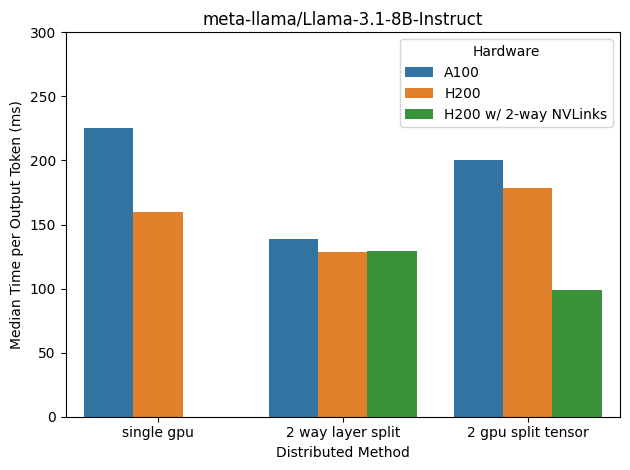

In [5]:
ax = sns.barplot(
    temp,
    x="Distributed Method",
    order=["single gpu", "2 way layer split", "2 gpu split tensor"],
    y="med-tpot",
    hue="Hardware",
    hue_order=["A100", "H200", "H200 w/ 2-way NVLinks"],
    palette=["tab:blue", "tab:orange", "tab:green"],
)
ax.set_ylabel("Median Time per Output Token (ms)")
ax.set_title("meta-llama/Llama-3.1-8B-Instruct")
ax.set_ylim([0, 300])
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("2-gpu-single-node.png")

## Single-node 4x GPU

In [6]:
temp = df[df["params"] == 70].copy()
temp["Hardware"] = temp["device"]+ np.where(temp["device"] == "H200", " w/ 2-way NVLinks", "")
temp["Distributed Method"] = \
    temp["tensor-parallel"].astype(str) + " gpu split tensor\n" + \
    temp["pipeline-parallel"].astype(str) + " way layer split"
temp

,params,device,nvlink,tensor-parallel,pipeline-parallel,path,med-tpot,Hardware,Distributed Method
8,70,A100,None,2,2,llama-3.1-70b-a100-tp2-pp2.txt,905.54,A100,2 gpu split tensor\n2 way layer split
9,70,A100,None,4,0,llama-3.1-70b-a100-tp4-pp0.txt,912.40,A100,4 gpu split tensor\n0 way layer split
10,70,H200,None,0,4,llama-3.1-70b-h200-tp0-pp4.txt,380.89,H200 w/ 2-way NVLinks,0 gpu split tensor\n4 way layer split
11,70,H200,None,2,2,llama-3.1-70b-h200-tp2-pp2.txt,406.19,H200 w/ 2-way NVLinks,2 gpu split tensor\n2 way layer split
12,70,H200,None,4,0,llama-3.1-70b-h200-tp4-pp0.txt,782.66,H200 w/ 2-way NVLinks,4 gpu split tensor\n0 way layer split


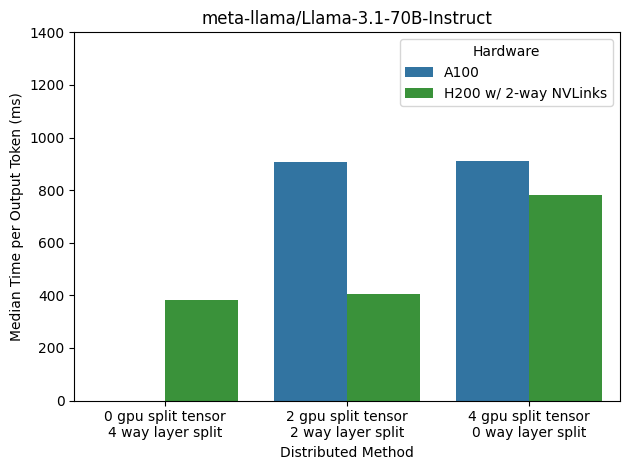

In [7]:
ax = sns.barplot(
    temp,
    x="Distributed Method",
    order=["0 gpu split tensor\n4 way layer split", "2 gpu split tensor\n2 way layer split", "4 gpu split tensor\n0 way layer split"],
    y="med-tpot",
    hue="Hardware",
    hue_order=["A100", "H200 w/ 2-way NVLinks"],
    palette=["tab:blue", "tab:green"],
)
ax.set_ylabel("Median Time per Output Token (ms)")
ax.set_title("meta-llama/Llama-3.1-70B-Instruct")
ax.set_ylim([0, 1400])
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("4-gpu-single-node.png")

## 2-node 8x GPU

In [8]:
temp = df[df["params"] == 405].copy()
temp["Hardware"] = "H200 w/ 2-way NVLinks"
temp["Distributed Method"] = \
    temp["tensor-parallel"].astype(str) + " gpu split tensor\n" + \
    temp["pipeline-parallel"].astype(str) + " way layer split"
temp

,params,device,nvlink,tensor-parallel,pipeline-parallel,path,med-tpot,Hardware,Distributed Method
13,405,H200,None,0,8,llama-3.1-405b-tp0-pp8.txt,1010.34,H200 w/ 2-way NVLinks,0 gpu split tensor\n8 way layer split
14,405,H200,None,2,4,llama-3.1-405b-tp2-pp4.txt,1129.24,H200 w/ 2-way NVLinks,2 gpu split tensor\n4 way layer split
15,405,H200,None,4,2,llama-3.1-405b-tp4-pp2.txt,2067.65,H200 w/ 2-way NVLinks,4 gpu split tensor\n2 way layer split
16,405,H200,None,8,0,llama-3.1-405b-tp8-pp0.txt,23730.03,H200 w/ 2-way NVLinks,8 gpu split tensor\n0 way layer split


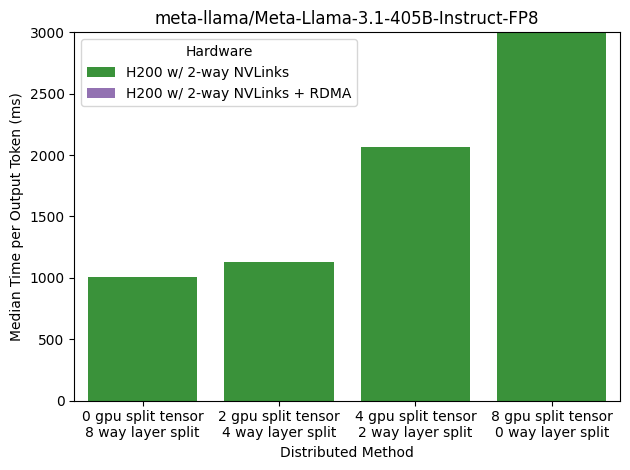

In [9]:
ax = sns.barplot(
    temp,
    x="Distributed Method",
    order=["0 gpu split tensor\n8 way layer split", "2 gpu split tensor\n4 way layer split", "4 gpu split tensor\n2 way layer split", "8 gpu split tensor\n0 way layer split"],
    y="med-tpot",
    hue="Hardware",
    hue_order=["H200 w/ 2-way NVLinks", "H200 w/ 2-way NVLinks + RDMA"],
    palette=["tab:green", "tab:purple"],
)
ax.set_ylabel("Median Time per Output Token (ms)")
ax.set_title("meta-llama/Meta-Llama-3.1-405B-Instruct-FP8")
ax.set_ylim([0, 3000])
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("8-gpu-double-node.png")